In [1]:
%pip install mosaicml
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.3/571.3 kB 10.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 12.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 6.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 4.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 6.4 MB/s eta 0:00:00
  Using cached yarl-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (268 kB)
     ━━━━━━━━━━━━━━━━━━━━━━

In [48]:
from numpy.random import seed
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
import torch.nn.functional as F

from composer.models import ComposerModel
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision import transforms, datasets

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import time
import torchmetrics

import torch.optim as optim
from composer import Trainer
import composer
from composer.algorithms import BlurPool
from composer.loggers import InMemoryLogger

import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns



In [3]:
base_dir='./data/ham10000'

In [4]:
def create_folder_struct():
    train_dir = os.path.join(base_dir, 'Train')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'Test')
    os.mkdir(val_dir)


    # [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    nv = os.path.join(train_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(train_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(train_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(train_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(train_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(train_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(train_dir, 'df')
    os.mkdir(df)



    # create new folders inside val_dir
    nv = os.path.join(val_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(val_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(val_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(val_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(val_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(val_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(val_dir, 'df')
    os.mkdir(df)

In [5]:
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Test')

In [6]:
# create_folder_struct()

In [7]:
df_data=pd.read_csv(base_dir+'/HAM10000_metadata')

In [8]:
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [9]:
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head(100)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
95,HAM_0000132,1,1,1,1,1,1,1
96,HAM_0000133,1,1,1,1,1,1,1
97,HAM_0000134,1,1,1,1,1,1,1
98,HAM_0000137,1,1,1,1,1,1,1


In [10]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates


In [11]:
df_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,has_duplicates


In [12]:
df_data['duplicates'].value_counts()


no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [13]:
#in df we store dataset with no duplicates
df=df_data[df_data['duplicates'] == 'no_duplicates']

df.shape


(5514, 9)

We have 5514 unique skin lesion image


In [14]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,vidir_modern,no_duplicates
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,vidir_modern,no_duplicates
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,vidir_modern,no_duplicates
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,vidir_modern,no_duplicates
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,rosendahl,no_duplicates


In [15]:
y= df["dx"]

_, df_val = train_test_split(df, test_size=0.2, random_state=101, stratify=y)

df_val.shape

(1103, 9)

**dx** column uniquely identifies the class of each Image,

In [16]:
df_val['dx'].value_counts()


nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [17]:
#Helper Function to uniquely identify and remove validation dataset from original dataset where duplicates existed

def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


In [18]:
# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


8912
1103


In [19]:
#value count the class in train dataset
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [20]:
part1=os.listdir(base_dir+'/HAM10000_images_part_1')
part2= os.listdir(base_dir+'/HAM10000_images_part_2')

In [21]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [22]:
df_data.set_index('image_id', inplace=True)

In [23]:
def transfer_train_images():
    for image in train_list:
    
        fname = image + '.jpg'
        label = df_data.loc[image,'dx']

        if fname in part1:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_1', fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

        if fname in part2:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_2', fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

In [24]:
# transfer_train_images()

In [25]:
def transfer_val_images():
    for image in val_list:
    
        fname = image + '.jpg'
        label = df_data.loc[image,'dx']

        if fname in part1:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_1', fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

        if fname in part2:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_2', fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

In [26]:
# transfer_val_images()

In [27]:
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [28]:
print(len(os.listdir(base_dir+'/Test/nv')))
print(len(os.listdir(base_dir+'/Test/mel')))
print(len(os.listdir(base_dir+'/Test/bkl')))
print(len(os.listdir(base_dir+'/Test//bcc')))
print(len(os.listdir(base_dir+'/Test/akiec')))
print(len(os.listdir(base_dir+'/Test/vasc')))
print(len(os.listdir(base_dir+'/Test/df')))

883
46
88
35
30
13
8


In [29]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

There is definitely a class imbalance in the provided dataset, one way to deal with it it so augmenting the class of images 

In [30]:
data_directory=base_dir+"/Train"
dataset = ImageFolder(root=data_directory)

In [31]:
dataset.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [32]:
def perform_augmentation():
    # note that we are not augmenting class 'nv'
    class_list = ['mel','bkl','bcc','akiec','vasc','df']

    for item in class_list:

        # We are creating temporary directories here because we delete these directories later
        # create a base dir
        aug_dir = 'aug_dir'
        os.mkdir(aug_dir)
        # create a dir within the base dir to store images of the same class
        img_dir = os.path.join(aug_dir, 'img_dir')
        os.mkdir(img_dir)

        # Choose a class
        img_class = item

        # list all images in that directory
        img_list = os.listdir(base_dir+'/Train/' + img_class)

        # Copy images from the class train dir to the img_dir e.g. class 'mel'
        for fname in img_list:
            # source path to image
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                src = os.path.join(base_dir+'/Train/' + img_class, fname)
                # destination path to image
                dst = os.path.join(img_dir, fname)
                # copy the image from the source to the destination
                shutil.copyfile(src, dst)


        # point to a dir containing the images and not to the images themselves
        path = aug_dir
        save_path = base_dir+'/Train/'  + img_class

        # Create a data generator
        datagen = ImageDataGenerator(
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            #brightness_range=(0.9,1.1),
            fill_mode='nearest')

        batch_size = 50

        aug_datagen = datagen.flow_from_directory(path,
                                               save_to_dir=save_path,
                                               save_format='jpg',
                                                        target_size=(224,224),
                                                        batch_size=batch_size)



        # Generate the augmented images and add them to the training folders

        ###########

        num_aug_images_wanted = 6000 # total number of images we want to have in each class

        ###########

        num_files = len(os.listdir(img_dir))
        num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

        # run the generator and create about 6000 augmented images
        for i in range(0,num_batches):

            imgs, labels = next(aug_datagen)

        # delete temporary directory with the raw image files
        shutil.rmtree('aug_dir')

In [33]:
# perform_augmentation()

In [34]:
# check how many train images we have in each folder

print('nv ------>', len(os.listdir(base_dir+'/Train/nv')))
print('mel ----->', len(os.listdir(base_dir+'/Train/mel')))
print('bkl ----->', len(os.listdir(base_dir+'/Train/bkl')))
print('bcc ----->', len(os.listdir(base_dir+'/Train//bcc')))
print('akiec --->', len(os.listdir(base_dir+'/Train/akiec')))
print('vasc ---->', len(os.listdir(base_dir+'/Train/vasc')))
print('df ------>', len(os.listdir(base_dir+'/Train/df')))

nv ------> 5822
mel -----> 5885
bkl -----> 5855
bcc -----> 5798
akiec ---> 5990
vasc ----> 5210
df ------> 4330


In [35]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
# plots(imgs, titles=None) # titles=labels will display the image labels

In [36]:
df_train

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates,train
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,has_duplicates,train


In [37]:
def requirementsForModelTraining(model):
    blurpool = BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    algorithms=[blurpool]
    return algorithms, optimizer

In [67]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def evaluate_model(model, num_of_classes=7):  
    model.eval()
    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            # Move data to the same device as the model (CPU or GPU)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, targets = inputs.to(device), targets.to(device)

            # Perform the forward pass and get the outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Accumulate the true labels and predicted labels for each batch
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    accuracyForEachClass = (TP + TN) / np.sum(conf_matrix)

    # Print the results
    accuracy = 100 * correct / total
    print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")
    print("\n")
    print("Accuracy:", accuracyForEachClass)

In [42]:
# Set your desired image size
image_size = 224

train_path=base_dir + '/Train/'
valid_path=base_dir + '/Test/'

# Define data transforms for training and validation datasets
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets from the directories using torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

# Create data loaders
train_batch_size = 10
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)

# Note: shuffle=False causes the test dataset to not be shuffled
test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)


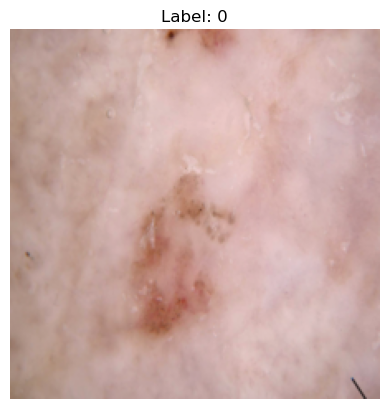

In [43]:

# Fetch one batch from the test_dataloader
for images, labels in test_dataloader:
    break

# Unnormalize the image data for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images.numpy().transpose((0, 2, 3, 1))
images = std * images + mean
images = np.clip(images, 0, 1)

# Display the image
plt.imshow(images[0])
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


In [44]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [77]:


class ResNetCustomModel(ComposerModel):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()

    def forward(self, batch):  # batch is the output of the dataloader
        # Determine the format of the batch and handle it accordingly
        if isinstance(batch, tuple):
            # If the batch is in the format (inputs, targets)
            inputs, targets = batch
        else:
            # If the batch is just the inputs
            inputs = batch

        return self.model(inputs)

    def loss(self, outputs, batch):
        # pass batches and `forward` outputs to the loss
        _, targets = batch
        return F.cross_entropy(outputs, targets)

In [78]:


resnetModel = ResNetCustomModel()


logger = InMemoryLogger()
trainer = Trainer(
    model=resnetModel,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='10ep',
    algorithms=algorithms,
    loggers=logger
)

In [67]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 6
blurpool/num_blurpool_layers: 1
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 2519990940

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 2124.1183 seconds to train


In [68]:
torch.save(model.state_dict(), 'trained_model_composer_10ep.pth')

Resnet Model without BlurPool

In [72]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in valid_dataloader:
        # Move data to the same device as the model (CPU or GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass (compute predictions)
        outputs = model(inputs)

        # Get the predicted class by finding the index with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate the total number of samples and correctly predicted samples
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate the overall accuracy
accuracy = 100 * correct / total
print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")


Accuracy on the evaluation dataset: 88.94%


In [79]:


modelWOBP = ResNetCustomModel()
optimizer = optim.Adam(modelWOBP.parameters(), lr=0.0001)

logger = InMemoryLogger()
trainerWOBP = Trainer(
    model=modelWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='10ep',
    loggers=logger
)

In [45]:
start_time = time.perf_counter()
trainerWOBP.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1127122937

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 2734.7752 seconds to train


In [46]:
modelWOBP.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in valid_dataloader:
        # Move data to the same device as the model (CPU or GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass (compute predictions)
        outputs = modelWOBP(inputs)

        # Get the predicted class by finding the index with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate the total number of samples and correctly predicted samples
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate the overall accuracy
accuracy = 100 * correct / total
print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")


Accuracy on the evaluation dataset: 87.85%


## Statistics

**ResNet18** with **BlurPool** gives an accuracy of **88.94%**

**ResNet18** without **BlurPool** gives an accuracy of **87.85%**

**Time To Train ResNet18** with BlurPool is 2124.83 seconds

**Time To Train ResNet18** without BlurPool is 2734.7752 seconds

In [ ]:
torch.cuda.empty_cache()

**EfficientNet**

In [39]:
# Set your desired image size
image_size = 320

train_path=base_dir + '/Train/'
valid_path=base_dir + '/Test/'

# Define data transforms for training and validation datasets
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets from the directories using torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

# Create data loaders
train_batch_size = 8
val_batch_size = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)

# Note: shuffle=False causes the test dataset to not be shuffled
test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)


In [40]:
class EfficientNetB3(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b3()
        
        # Modify the final classification head
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = torch.nn.Linear(in_features, num_classes)
        
        self.num_classes = num_classes
        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        # Print the number of classes attribute
        metric.update(outputs, targets)
        
    def _eval_train_metrics(self, device_batch):
            # Separate inputs and targets from the device_batch
            inputs, targets = device_batch

            # Set the model to evaluation mode
            self.model.eval()

            # Perform the forward pass and get the outputs
            with torch.no_grad():
                outputs = self.model(inputs)
                eval_outputs = self.eval_forward(device_batch, outputs)

            # Update the metrics with the computed outputs
            for _, metric in self.state.train_metrics.items():
                self.update_metric(device_batch, eval_outputs, metric)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [40]:
efficientModel = EfficientNetB3(num_classes=7)
algorithms, optimizer,  = requirementsForModelTraining(efficientModel)
logger = InMemoryLogger()
trainer = Trainer(
    model=efficientModel,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='10ep',
    algorithms=algorithms,
    loggers=logger
)

In [41]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 4
blurpool/num_blurpool_layers: 0
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 829998277

******************************


train          Epoch   0:    0%|| 0/4862 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 2 into batches of size 8. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


eval           Epoch   0:    0%|| 0/138 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 7 into batches of size 8. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/138 [00:00<?, ?ba/s]         

It took 6744.6352 seconds to train


In [43]:
# Set the model to evaluation mode
efficientModel.eval()
num_classes=7
correct = 0
total = 0
# Create a metric instance for accuracy
accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

# Iterate over the data loader and calculate accuracy
with torch.no_grad():
    for inputs, targets in valid_dataloader:
        # Move data to the same device as the model (CPU or GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs, targets = inputs.to(device), targets.to(device)

        # Perform the forward pass and get the outputs
        outputs = efficientModel(inputs)

        # Get the predicted class by finding the index with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate the total number of samples and correctly predicted samples
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
# Get the final accuracy value
accuracy = 100 * correct / total
print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")


Accuracy on the evaluation dataset: 87.76%


## Efficient Net Without Blurpool

In [41]:
efficientModelWOBP = EfficientNetB3(num_classes=7)
algorithms, optimizer,  = requirementsForModelTraining(efficientModelWOBP)
logger = InMemoryLogger()
trainer = Trainer(
    model=efficientModelWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='10ep',
    loggers=logger
)

In [42]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 2070618928

******************************


train          Epoch   0:    0%|| 0/4862 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 2 into batches of size 8. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


eval           Epoch   0:    0%|| 0/138 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 7 into batches of size 8. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/138 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/4862 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/138 [00:00<?, ?ba/s]         

It took 6686.8272 seconds to train


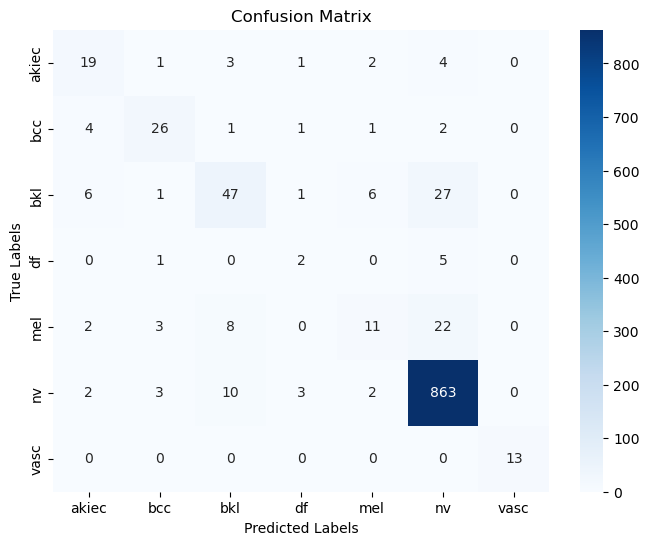

Accuracy on the evaluation dataset: 88.94%
Accuracy: [0.97733454 0.98368087 0.94288305 0.98912058 0.95829556 0.92747053
 1.        ]


In [66]:
evaluate_model(efficientModelWOBP)

# InceptionNet


In [60]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
from torchvision import transforms

from composer.models import ComposerModel
from composer.trainer import Trainer

class InceptionNet(ComposerModel):
    def __init__(self, num_classes, weights=None):
        super().__init__()
        self.model = torchvision.models.inception_v3()
        self.num_classes = num_classes

        # Modify the final classification head
        in_features = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features, num_classes)

        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch

        # Extract the necessary tensor from InceptionOutputs
        logits = outputs.logits

        return F.cross_entropy(logits, targets)

    def eval_forward(self, batch, outputs):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        metric.update(outputs, targets)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [63]:
inceptionModel = InceptionNet(num_classes=7, weights="imagenet1k-v1")
algorithms, optimizer = requirementsForModelTraining(inceptionModel)
logger = InMemoryLogger()
trainer = Trainer(
    model=inceptionModel,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='5ep',
    algorithms=algorithms,
    loggers=logger
)

start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
